# Stock clustering
Using unsupervised learning to group together stocks based on historical and metadata features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import f_oneway
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from tqdm import tqdm
from yellowbrick.cluster import KElbowVisualizer
from src.analysis.features import get_historical_features, get_stock_metadata
from src.db.main import DatabaseApi
from utils.plotting import get_subplot_shape
from utils.tickers import get_snp500_tickers

## Data processing
Get historical data

In [2]:
db = DatabaseApi()
stocks = get_snp500_tickers()

historical_data = db.request(stocks).dropna(axis=1, how='all')
historical_data.head()

[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  10 of 10 completed
[*****

/home/andrew/.cache/pypoetry/virtualenvs/stockbot-WOIy5_bY-py3.10/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'BF.B'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/andrew/.cache/pypoetry/virtualenvs/stockbot-WOIy5_bY-py3.10/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'BRK.B'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)


MTD                                         \
                                  Open         High          Low        Close   
2022-03-30 00:00:00-04:00  1410.819946  1416.050049  1394.890015  1405.739990   
2022-03-31 00:00:00-04:00  1407.270020  1412.780029  1370.719971  1373.189941   
2022-04-01 00:00:00-04:00  1381.810059  1387.150024  1346.569946  1371.630005   
2022-04-04 00:00:00-04:00  1368.729980  1376.880005  1350.140015  1357.430054   
2022-04-05 00:00:00-04:00  1346.219971  1362.310059  1331.270020  1349.010010   

                                                        AKAM              \
                             Adj Close    Volume        Open        High   
2022-03-30 00:00:00-04:00  1405.739990  102300.0  120.000000  121.199997   
2022-03-31 00:00:00-04:00  1373.189941  142700.0  121.440002  121.800003   
2022-04-01 00:00:00-04:00  1371.630005  189300.0  119.760002  120.620003   
2022-04-04 00:00:00-04:00  1357.430054  121100.0  120.720001  121.339996   
2022-04-05 00:00:00-04:00  1349.010010  169500.0  120.650002  122.010002   

                                                   ...         SJM  \
                                  Low       Close  ...         Low   
2022-03-30 00:00:00-04:00  119.589996  121.110001  ...  132.929993   
2022-03-31 00:00:00-04:00  119.360001  119.389999  ...  133.750000   
2022-04-01 00:00:00-04:00  119.239998  120.510002  ...  134.729996   
2022-04-04 00:00:00-04:00  120.279999  120.459999  ...  132.940002   
2022-04-05 00:00:00-04:00  119.790001  120.410004  ...  134.250000   

                                                                     PXD  \
                                Close   Adj Close     Volume        Open   
2022-03-30 00:00:00-04:00  134.880005  131.126663   715200.0  256.880005   
2022-03-31 00:00:00-04:00  135.410004  131.641922   666000.0  254.809998   
2022-04-01 00:00:00-04:00  137.509995  133.683472   739300.0  250.000000   
2022-04-04 00:00:00-04:00  134.639999  130.893341   711000.0  253.149994   
2022-04-05 00:00:00-04:00  137.770004  133.936249  1134000.0  252.789993   

                                                                           \
                                 High         Low       Close   Adj Close   
2022-03-30 00:00:00-04:00  260.000000  254.639999  257.929993  230.502457   
2022-03-31 00:00:00-04:00  259.500000  249.860001  250.029999  223.442535   
2022-04-01 00:00:00-04:00  254.600006  249.839996  253.149994  226.230759   
2022-04-04 00:00:00-04:00  255.029999  250.020004  252.750000  225.873306   
2022-04-05 00:00:00-04:00  255.779999  244.229996  244.479996  218.482712   

                                      
                              Volume  
2022-03-30 00:00:00-04:00  1934700.0  
2022-03-31 00:00:00-04:00  2008300.0  
2022-04-01 00:00:00-04:00  1257100.0  
2022-04-04 00:00:00-04:00  1181200.0  
2022-04-05 00:00:00-04:00  1150900.0  

[5 rows x 3006 columns]

Convert historical data to features

In [61]:
historical_df = get_historical_features(historical_data).sort_index()
historical_df.head()

,volatility,avg_volume,avg_price_range
A,0.016252,1.360263e+06,3.347042
AAL,0.025413,2.465034e+07,0.516479
AAP,0.017155,1.281644e+06,3.401831
AAPL,0.016178,7.188044e+07,3.405210
ABBV,0.011505,6.190413e+06,2.719155


Get metadata for each stock

In [62]:
metadata_df = get_stock_metadata(stocks)
metadata_df.head()

,language,region,quoteType,typeDisp,quoteSourceName,triggerable,customPriceAlertConfidence,currency,marketState,regularMarketOpen,...,askSize,fullExchangeName,financialCurrency,regularMarketChangePercent,regularMarketPrice,displayName,price,prevName,nameChangeDate,ipoExpectedDate
A,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,139.19,...,14,NYSE,USD,-2.310510,135.72,Agilent,135.72,NaN,NaN,NaN
AAL,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,15.98,...,22,NasdaqGS,USD,-2.644837,15.46,American Airlines,15.46,NaN,NaN,NaN
AAP,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,129.12,...,9,NYSE,USD,-1.378733,128.04,Advance Auto Parts,128.04,NaN,NaN,NaN
AAPL,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,150.21,...,11,NasdaqGS,USD,-1.387872,148.50,Apple,148.50,NaN,NaN,NaN
ABBV,en-US,US,EQUITY,Equity,Delayed Quote,True,HIGH,USD,CLOSED,147.84,...,8,NYSE,USD,1.601629,149.71,AbbVie,149.71,NaN,NaN,NaN


Combine chosen features

In [63]:
historical_features = ["volatility", "avg_volume", "avg_price_range"]
metadata_features = ["trailingAnnualDividendRate", "trailingPE", "trailingAnnualDividendYield", "epsTrailingTwelveMonths", "marketCap", "priceToBook"]

features_df = pd.merge(historical_df[historical_features], metadata_df[metadata_features], left_index=True, right_index=True, how='inner')
features_df = features_df.dropna(axis=0, how='any')

features_df.head()

,volatility,avg_volume,avg_price_range,trailingAnnualDividendRate,trailingPE,trailingAnnualDividendYield,epsTrailingTwelveMonths,marketCap,priceToBook
A,0.016252,1.360263e+06,3.347042,0.855,31.271889,0.006154,4.34,4.013268e+10,7.157850
AAL,0.025413,2.465034e+07,0.516479,0.000,85.888885,0.000000,0.18,1.007112e+10,-1.734545
AAP,0.017155,1.281644e+06,3.401831,6.000,15.691176,0.046214,8.16,7.589417e+09,2.814375
AAPL,0.016178,7.188044e+07,3.405210,0.910,25.212225,0.006043,5.89,2.349552e+12,41.468860
ABBV,0.011505,6.190413e+06,2.719155,5.710,22.212168,0.038751,6.74,2.648969e+11,15.350149


Scale features

In [64]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# create a new dataframe with the same columns and index, but scaled values
scaled_features_df = pd.DataFrame(data=scaled_features, columns=features_df.columns, index=features_df.index)
scaled_features_df.head()

,volatility,avg_volume,avg_price_range,trailingAnnualDividendRate,trailingPE,trailingAnnualDividendYield,epsTrailingTwelveMonths,marketCap,priceToBook
A,-0.292396,-0.307656,-0.111189,-0.524243,-0.004639,-0.763556,-0.173103,-0.181566,-0.012749
AAL,0.909614,1.838146,-0.502554,-0.864004,1.055747,-1.106383,-0.344596,-0.355863,-0.148791
AAP,-0.173961,-0.314899,-0.103614,1.520285,-0.307138,1.468045,-0.015627,-0.370252,-0.079199
AAPL,-0.302114,6.189630,-0.103147,-0.502387,-0.122287,-0.769755,-0.109206,13.208466,0.512164
ABBV,-0.915194,0.137364,-0.198003,1.405045,-0.180533,1.052308,-0.074166,1.121619,0.112582


## Initial model
Create model with all features, visualise scores for different increasing number of clusters

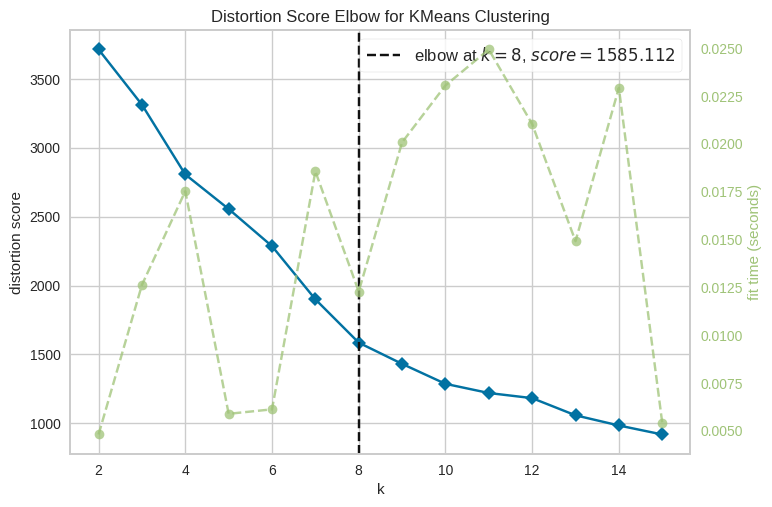

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [65]:
kmeans = KMeans(n_init="auto", random_state=42)
kmeans_visual = KElbowVisualizer(kmeans, k=(2, 16)).fit(scaled_features_df.values)
kmeans_visual.show()

Choose number of clusters based on elbow point and refit 

In [66]:
kmeans.n_clusters = kmeans_visual.elbow_value_
kmeans = kmeans.fit(scaled_features_df.values)

Visualise results in 2D using PCA

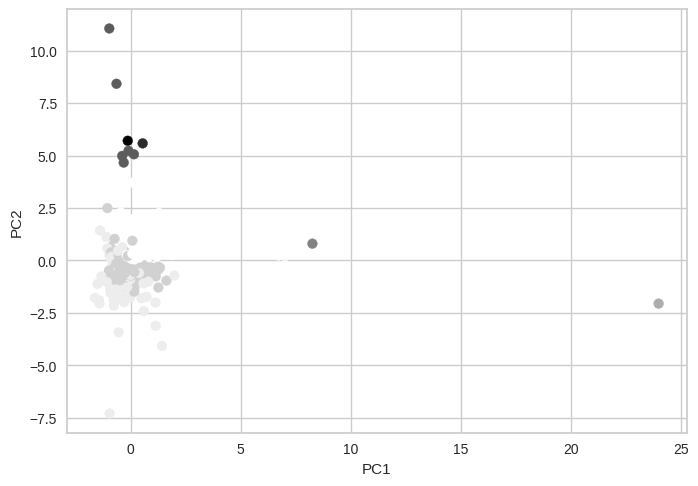

In [67]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(scaled_features_df.values)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Visualise clusters across every pair of features

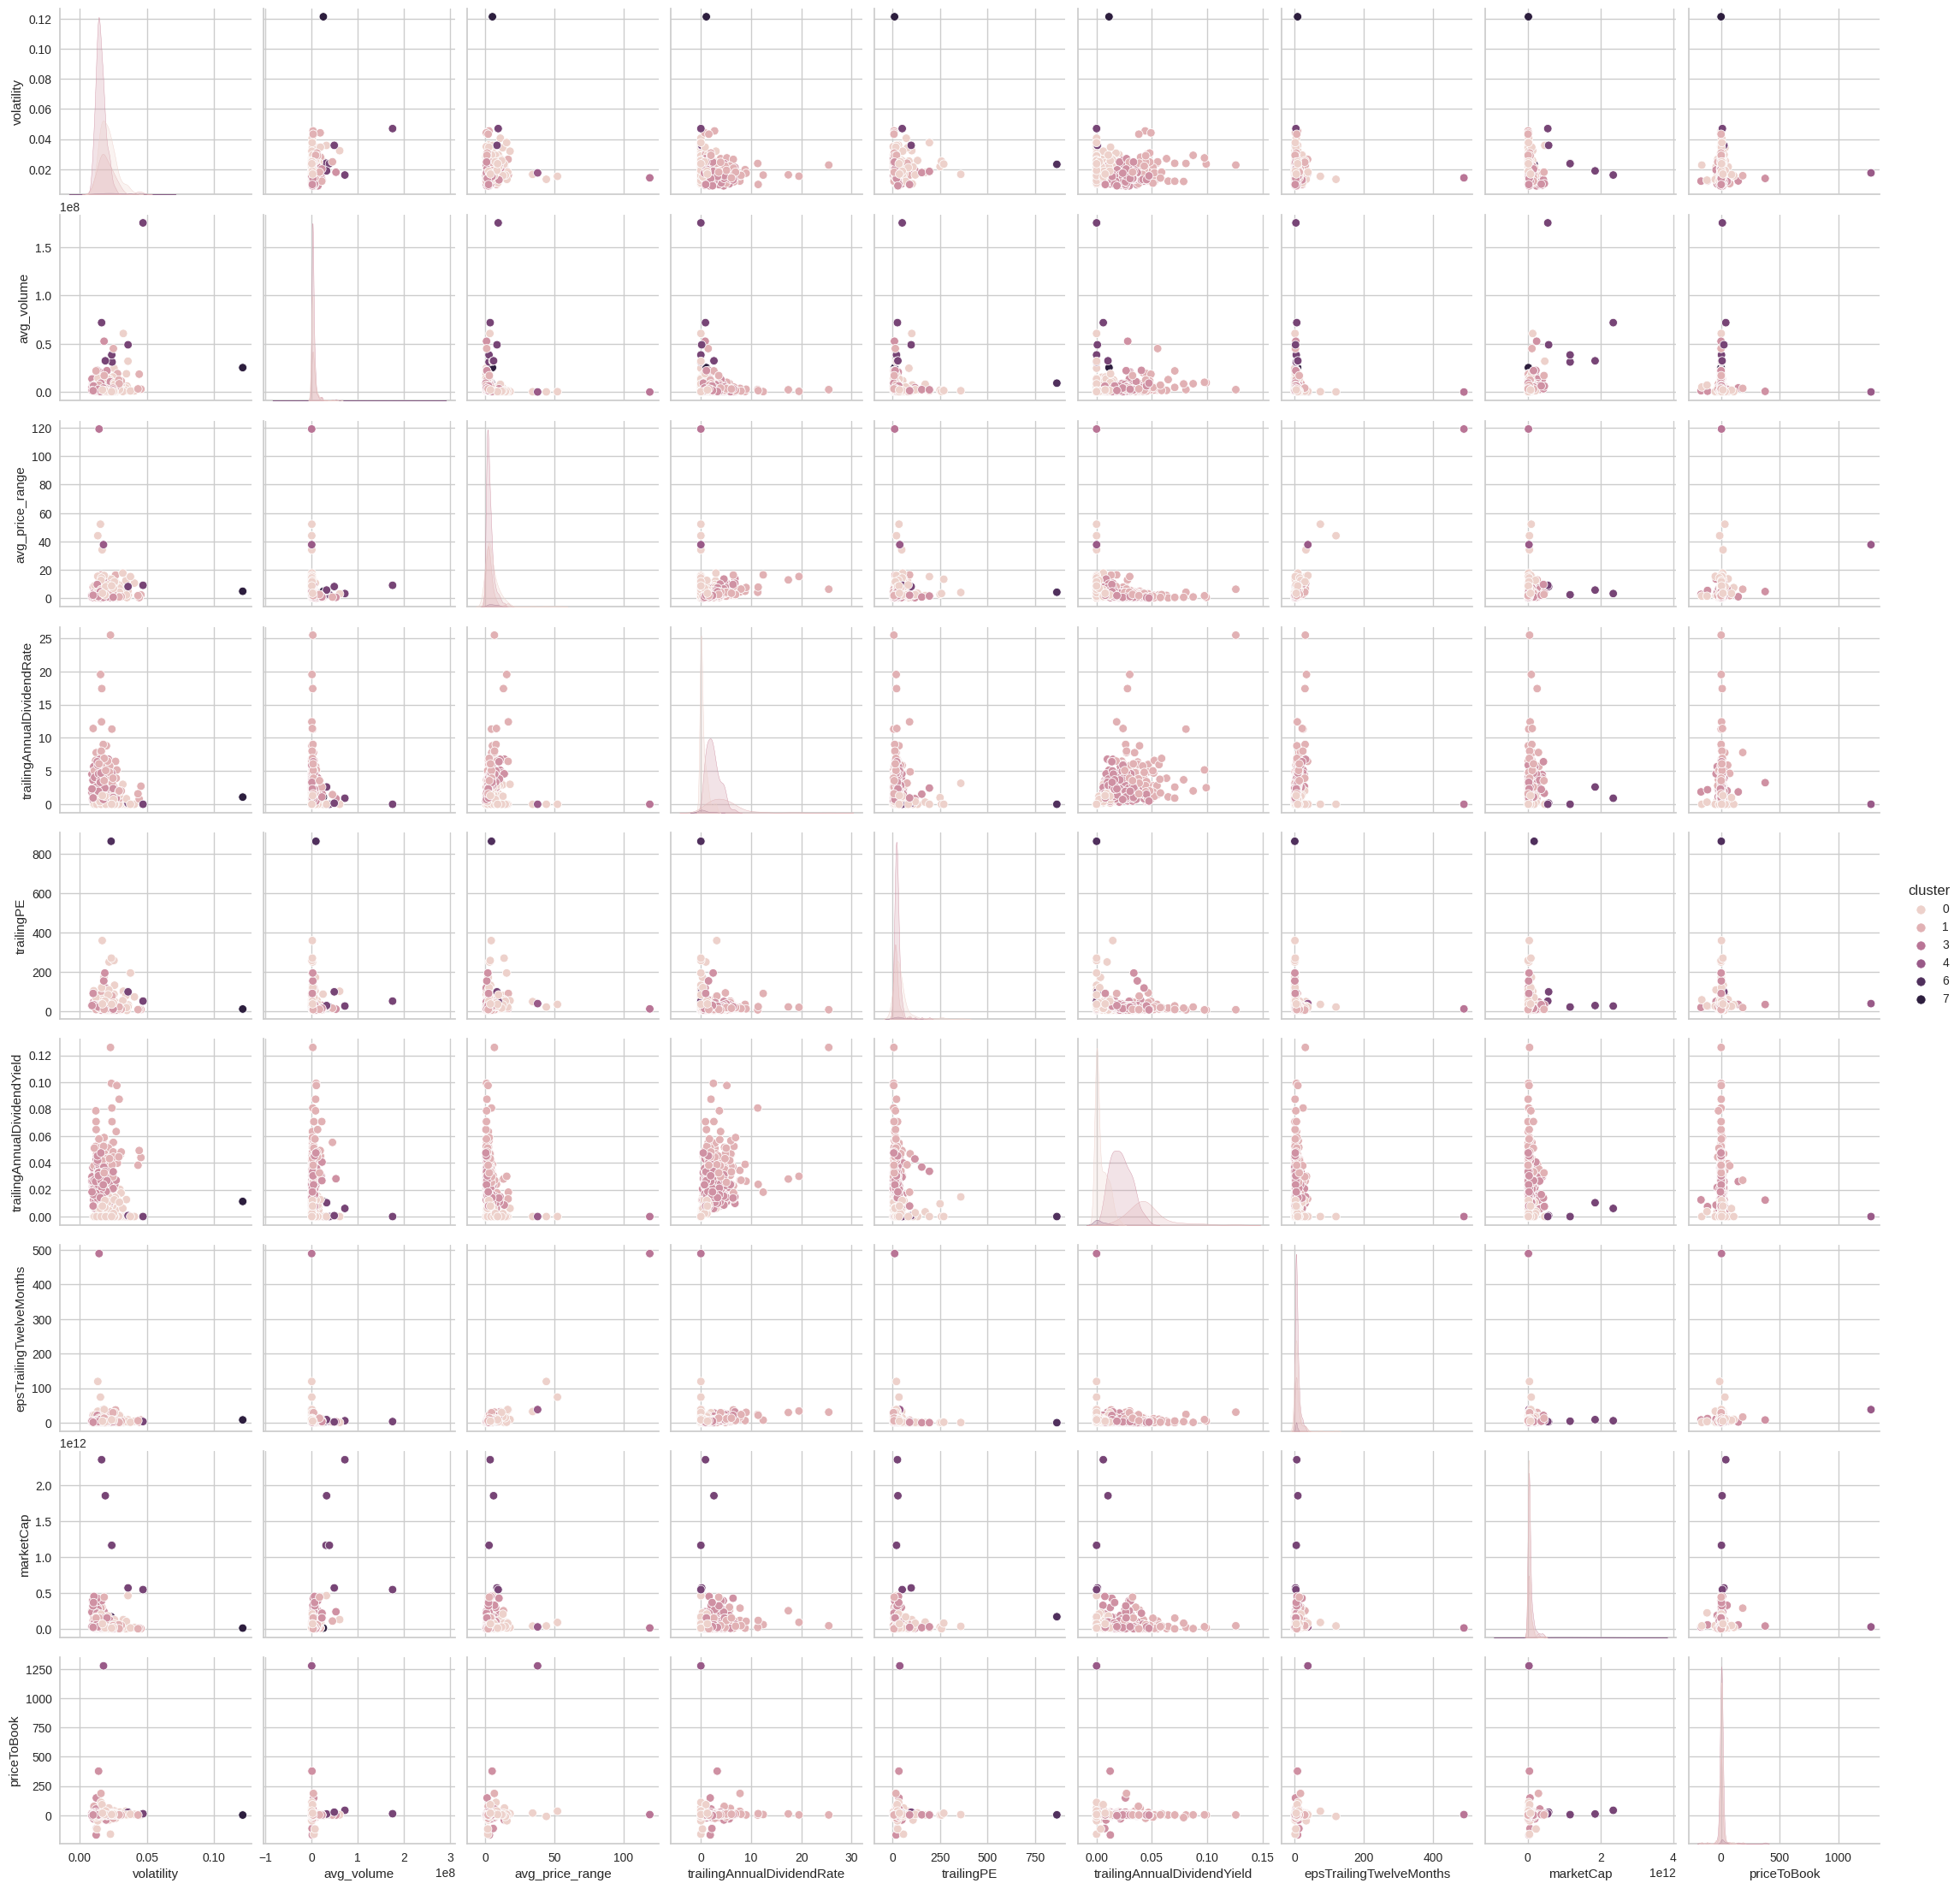

In [68]:
results = features_df.copy()

# Add the cluster labels to the features DataFrame
results['cluster'] = kmeans.labels_

# Create scatter plots of each pair of variables, colored by cluster label
sns.pairplot(results, vars=results.columns[:-1], hue='cluster')
plt.show()

## Modelling feature combinations
Creating a number of models based on different feature combinations.

Select features to be used in every model, the rest will be optional and all combintations will be checked.

In [70]:
constant_features = []
min_optional_features = 1

optional_features = list(set(features_df.columns.tolist()) - set(constant_features))

# Create list of feature combinations to test
combinations_to_test = []
for i in range(min_optional_features, len(optional_features)+1):

    optional_combos = combinations(optional_features, i)
    combinations_to_test.extend(tuple(constant_features) + tuple(opt) for opt in optional_combos)

print(
    f"Number of constant features: {len(constant_features)}", 
    f"Number of optional features: {len(optional_features)}", 
    f"Total combinations to test: {len(combinations_to_test)}", 
    sep="\n"
)

Number of constant features: 0
Number of optional features: 9
Total combinations to test: 511


Run all combinations and store results

100%|██████████| 511/511 [03:56<00:00,  2.16it/s]


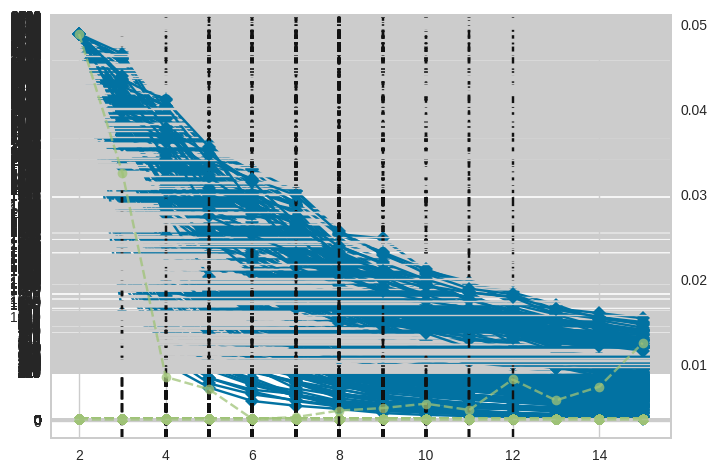

In [71]:
results = []

for combo in tqdm(combinations_to_test):

    combo_scaled_features = scaled_features_df[list(combo)].values

    kmeans = KMeans(n_init="auto", random_state=42)
    kmeans_visual = KElbowVisualizer(kmeans, k=(2, 16)).fit(combo_scaled_features)
    
    kmeans.n_clusters = kmeans_visual.elbow_value_
    kmeans = kmeans.fit(combo_scaled_features)

    # Calculate metrics
    wss = kmeans.inertia_
    ssb = 0 # calc_ssb(kmeans, combo_scaled_features)
    silhouette = silhouette_score(combo_scaled_features, kmeans.labels_)
    
    # add results to dataframe
    results.append({
        'features': list(combo),
        'n_clusters': kmeans.n_clusters,
        'wss': wss,
        'wss_norm': wss / len(combo),
        'ssb': ssb,
        'silhouette': silhouette
    })

results_df = pd.DataFrame(results)

Sort values by metrics

In [74]:
results_df = results_df.sort_values(by='silhouette', ascending=False)
results_df.head(10)

,features,n_clusters,wss,wss_norm,ssb,silhouette
25,"[priceToBook, epsTrailingTwelveMonths]",3,145.249146,72.624573,0,0.972004
74,"[marketCap, priceToBook, epsTrailingTwelveMonths]",4,274.931253,91.643751,0,0.915106
2,[priceToBook],5,12.010445,12.010445,0,0.907859
263,"[avg_price_range, marketCap, priceToBook, epsT...",5,610.940334,122.188067,0,0.874281
273,"[avg_price_range, marketCap, trailingPE, epsTr...",3,1178.021615,235.604323,0,0.852765
29,"[priceToBook, avg_volume]",4,156.691881,78.345940,0,0.846582
45,"[avg_price_range, marketCap, priceToBook]",5,304.427929,101.475976,0,0.846521
78,"[marketCap, priceToBook, avg_volume]",5,269.277985,89.759328,0,0.832840
38,"[epsTrailingTwelveMonths, avg_volume]",4,142.030800,71.015400,0,0.832072
24,"[priceToBook, trailingPE]",4,152.603017,76.301508,0,0.822879


Save results to csv

In [75]:
results_df.to_csv('cluster_results.csv')

### Further evaluation
Choose model to explore further

In [76]:
model_df = results_df.iloc[3, :]
model_df

features      [avg_price_range, marketCap, priceToBook, epsT...
n_clusters                                                    5
wss                                                  610.940334
wss_norm                                             122.188067
ssb                                                           0
silhouette                                             0.874281
Name: 263, dtype: object

Fit the model

In [77]:
model_features_df = scaled_features_df[model_df["features"]].copy()
kmeans = KMeans(n_clusters=model_df["n_clusters"], n_init="auto", random_state=42).fit(model_features_df.values)

Visualise results: metrics and pair plot

Features: ['avg_price_range', 'marketCap', 'priceToBook', 'epsTrailingTwelveMonths', 'avg_volume']
Silhouette score: 0.8742811499867255
Elbow value: 5
cluster
0    453
2      4
1      1
3      1
4      1
dtype: int64


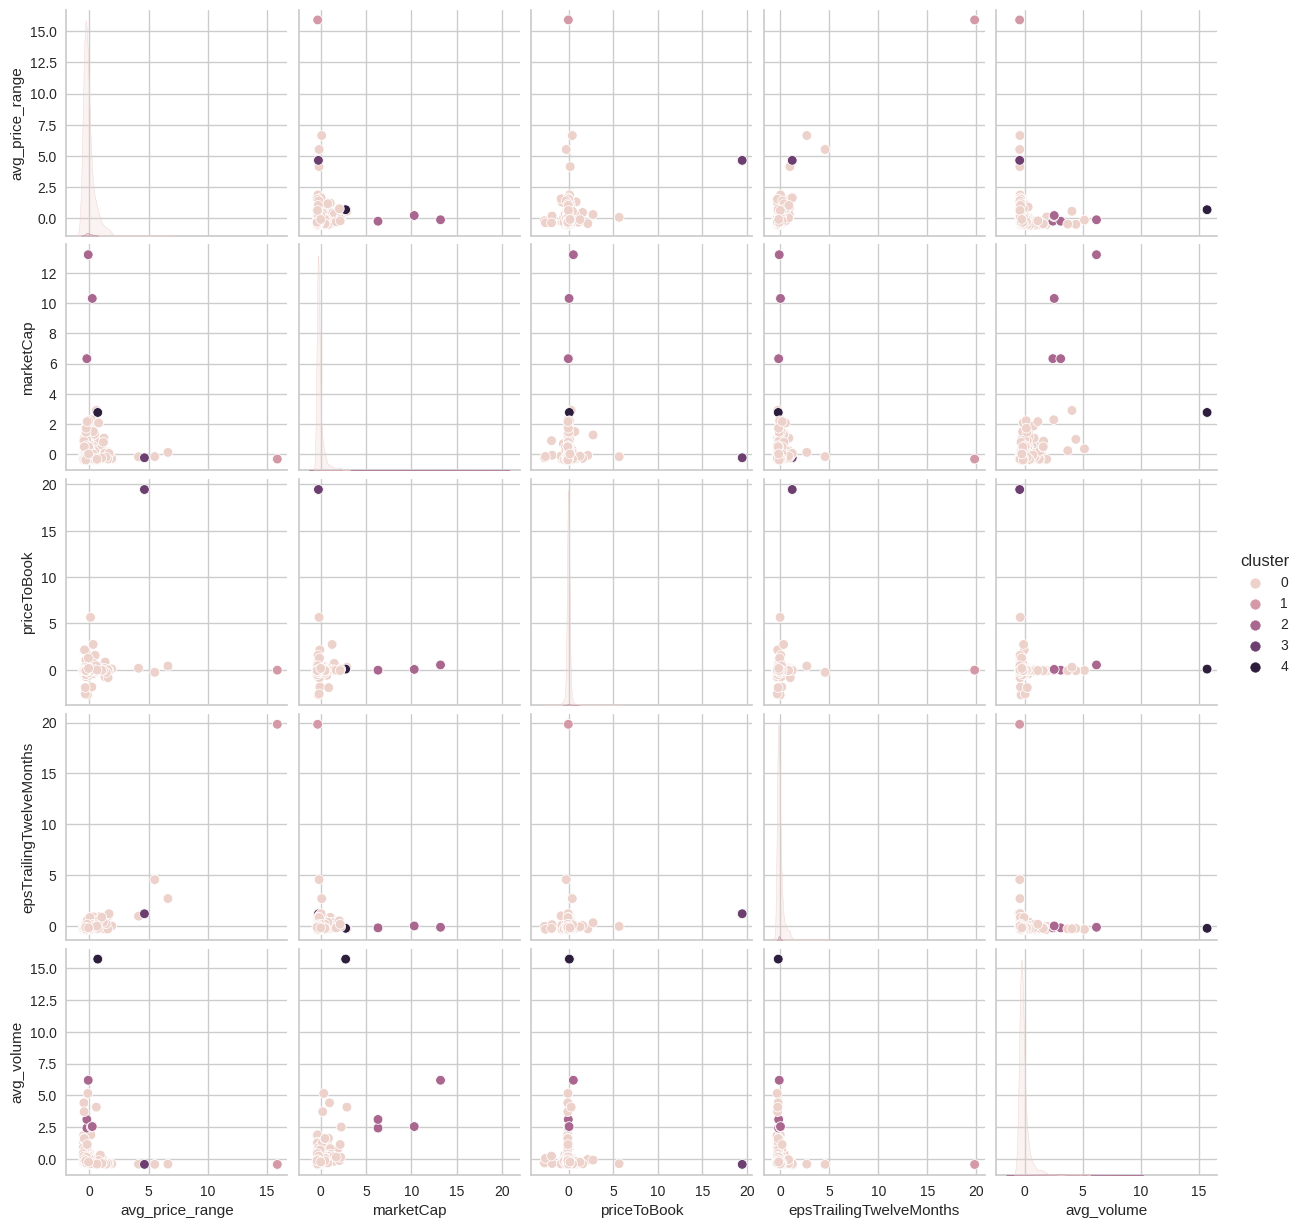

In [78]:
model_results_df = model_features_df.copy()

# Add the cluster labels to the features DataFrame
model_results_df['cluster'] = kmeans.labels_
print(f"Features: {model_df['features']}",  f"Silhouette score: {model_df['silhouette']}", f"Elbow value: {model_df['n_clusters']}", sep="\n")
print(model_results_df.value_counts('cluster'))

# Create scatter plots of each pair of variables, colored by cluster label
sns.pairplot(model_results_df, vars=model_df["features"], hue='cluster')
plt.show()

Box plots to view distributions within clusters

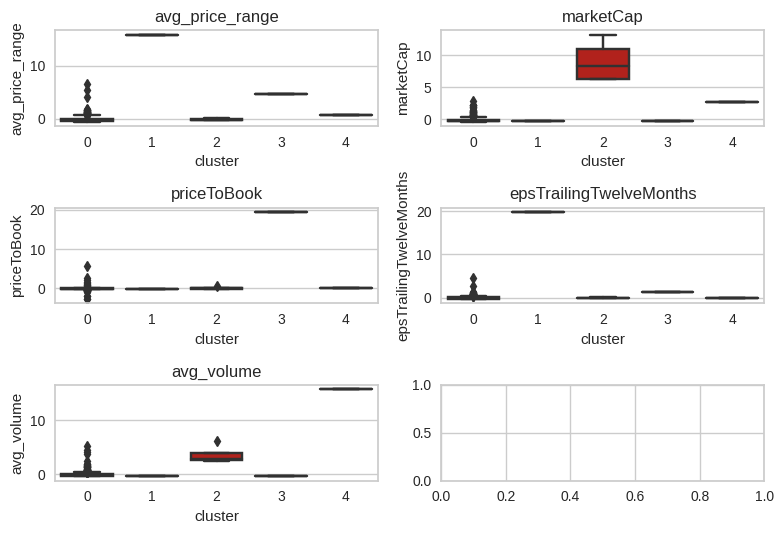

In [79]:
num_features = len(model_df["features"])

num_rows, num_cols = get_subplot_shape(num_features)
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)
axes = np.ravel(axes)

for i, feature in enumerate(model_df["features"]):
    sns.boxplot(data=model_results_df, x='cluster', y=feature, ax=axes[i])
    axes[i].set_title(feature)

plt.tight_layout()
plt.show()

Identify which features lead to significant differences in the means between different clusters

In [80]:
# loop over each feature and perform ANOVA test
for feature in model_df['features']:
    
    # create a list of series, one for each cluster
    series_list = []
    for cluster in model_results_df['cluster'].unique():
        cluster_data = model_results_df[model_results_df['cluster'] == cluster][feature]
        series_list.append(cluster_data)
    
    # perform ANOVA test
    f_value, p_value = f_oneway(*series_list)
    
    # print results
    print(
        f"Feature: {feature}",
        f"F-value: {f_value:.2f}",
        f"P-value: {p_value:.2f}",
        sep="\n"
    )

Feature: avg_price_range
F-value: 170.11
P-value: 0.00
Feature: marketCap
F-value: 316.30
P-value: 0.00
Feature: priceToBook
F-value: 535.75
P-value: 0.00
Feature: epsTrailingTwelveMonths
F-value: 696.99
P-value: 0.00
Feature: avg_volume
F-value: 213.63
P-value: 0.00
